# About

In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](pic/pid.jpg)

You task is to identify a particle type using the responses in the detector systems. 

# Attention

Data files you should download from https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2

In [4]:
!pip install tensorflow==1.15

%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

ImportError: /home/taylorc/anaconda3/envs/coursera-LHC/lib/python3.6/site-packages/numpy/core/../../../.././libgfortran.so.5: version `GFORTRAN_7' not found (required by /home/taylorc/anaconda3/envs/coursera-LHC/lib/python3.6/site-packages/scipy/special/_ufuncs.cpython-36m-x86_64-linux-gnu.so)

# Download data

Download data used to train classifiers.

### Read training file

In [2]:
data = pandas.read_csv('training.csv.gz')

NameError: name 'pandas' is not defined

In [ ]:
data.head()

### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### Look at the labels set

The training data contains six classes. Each class corresponds to a particle type. Your task is to predict type of a particle.

In [10]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Convert the particle types into class numbers.

In [11]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Define training features

The following set of features describe particle responses in the detector systems:

![features](pic/features.jpeg)

Also there are several combined features. The full list is following.

In [12]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['TrackNDoFSubdetector2',
 'DLLmuon',
 'RICHpFlagElectron',
 'MuonLLbeBCK',
 'Calo2dFitQuality',
 'HcalDLLbeMuon',
 'MuonLLbeMuon',
 'TrackNDoF',
 'SpdE',
 'RICH_DLLbeKaon',
 'RICH_DLLbeProton',
 'FlagEcal',
 'GhostProbability',
 'EcalShowerLongitudinalParameter',
 'TrackDistanceToZ',
 'RICHpFlagProton',
 'RICHpFlagKaon',
 'RICH_DLLbeMuon',
 'FlagMuon',
 'EcalDLLbeElectron',
 'HcalDLLbeElectron',
 'RICHpFlagPion',
 'RICH_DLLbeElectron',
 'TrackNDoFSubdetector1',
 'FlagSpd',
 'TrackP',
 'DLLelectron',
 'FlagPrs',
 'FlagBrem',
 'RICH_DLLbeBCK',
 'TrackQualitySubdetector2',
 'MuonFlag',
 'PrsDLLbeElectron',
 'DLLproton',
 'TrackQualitySubdetector1',
 'RICHpFlagMuon',
 'DLLkaon',
 'Calo3dFitQuality',
 'FlagHcal',
 'FlagRICH1',
 'PrsE',
 'MuonLooseFlag',
 'FlagRICH2',
 'TrackQualityPerNDoF',
 'TrackPt',
 'BremDLLbeElectron',
 'EcalE',
 'EcalDLLbeMuon',
 'HcalE']

### Divide training data into 2 parts

In [13]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.90)

In [14]:
len(training_data), len(validation_data)

(1080000, 120000)

# Sklearn classifier

On this step your task is to train **Sklearn** classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [16]:
%%time 

scaler = StandardScaler()
training_scale = scaler.fit_transform(training_data[features].values)
validation_scale = scaler.transform(validation_data[features].values)

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.8, random_state=13,
                                min_samples_leaf=1, max_depth=3)
gb.fit(training_scale, training_data.Class.values)

CPU times: user 1h 9min 39s, sys: 3.46 s, total: 1h 9min 43s
Wall time: 1h 9min 43s


GradientBoostingClassifier(n_estimators=50, random_state=13, subsample=0.8)

### Log loss on the cross validation sample

In [18]:
# predict each track
proba_gb = gb.predict_proba(validation_data[features].values)

In [19]:
log_loss(validation_data.Class.values, proba_gb)

1.3835402899358822

# Keras neural network

On this step your task is to train **Keras** NN classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can. Data preprocessing may help you to improve your score.

In [31]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

ImportError: Traceback (most recent call last):
  File "/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: /home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so: invalid ELF header


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [23]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [24]:
nn = nn_model(len(features))

nn.fit(training_scaled,
       np_utils.to_categorical(training_data.Class.values), 
       verbose=1, 
       epochs=5, 
       batch_size=256)

NameError: name 'Sequential' is not defined

### Log loss on the cross validation sample

In [64]:
# predict each track
proba_nn = nn.predict_proba(validation_data[features].values)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [46]:
log_loss(validation_data.Class.values, proba_nn)

TypeError: Singleton array array(947078) cannot be considered a valid collection.

# Quality metrics

Plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [47]:
proba = proba_gb

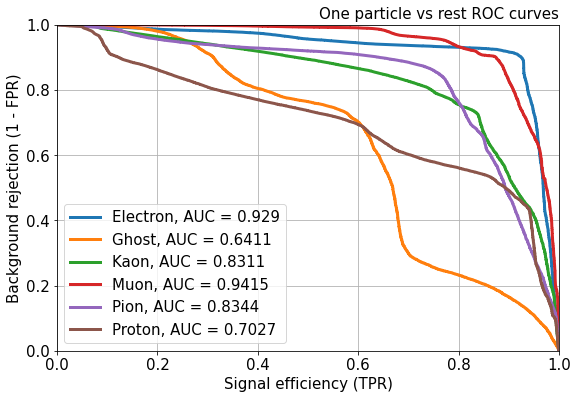

In [48]:
utils.plot_roc_curves(proba, validation_data.Class.values)

/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week2/utils.py:132: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week2/utils.py:132: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week

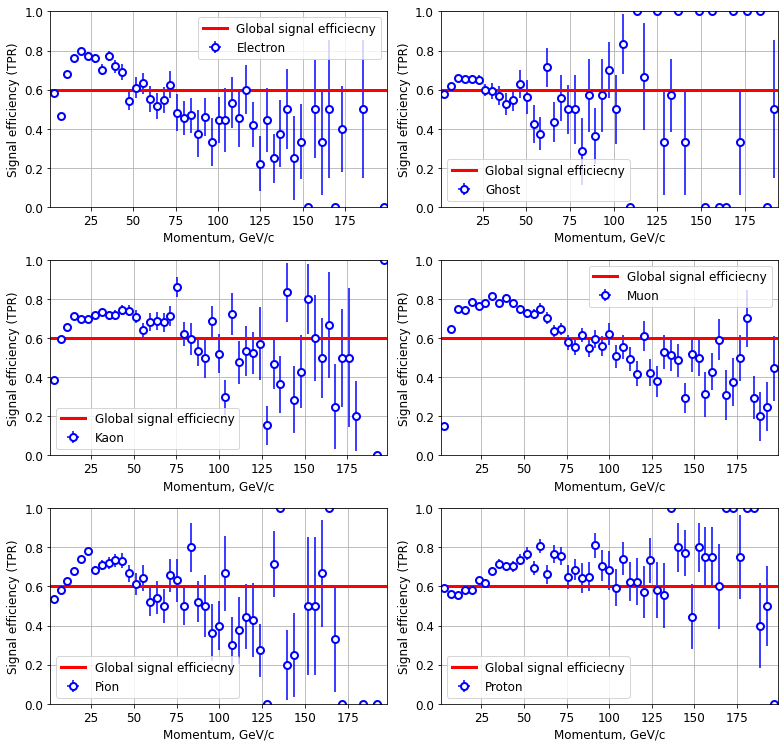

In [49]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week2/utils.py:132: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week2/utils.py:132: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week

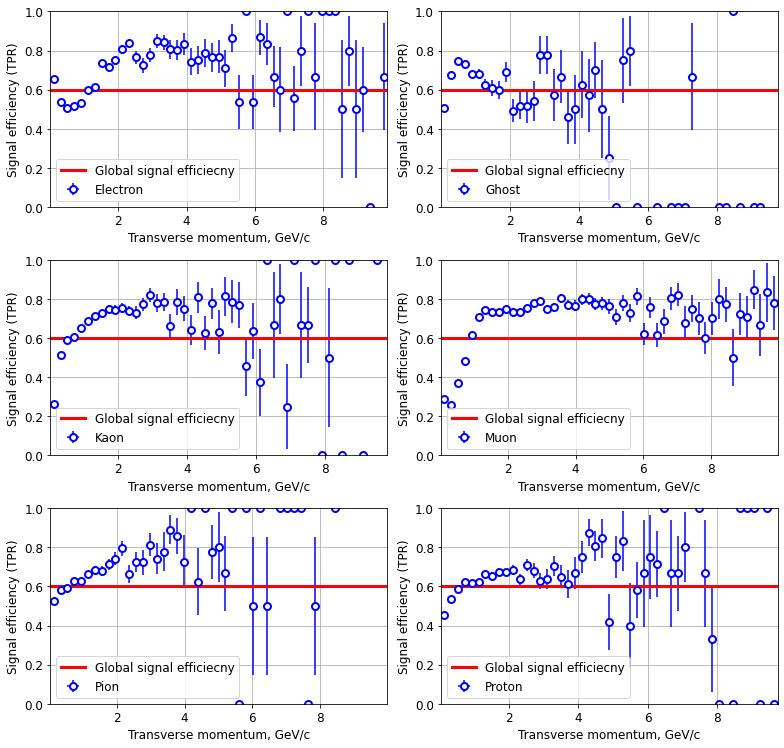

In [50]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Prepare submission

Select your best classifier and prepare submission file.

In [51]:
test = pandas.read_csv('test.csv.gz')

In [52]:
best_model = gb

In [53]:
# predict test sample
submit_proba = best_model.predict_proba(test[features])
submit_ids = test.ID

/home/taylorc/anaconda3/envs/coursera-advanced-ml/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [55]:
from IPython.display import FileLink
utils.create_solution(submit_ids, submit_proba, filename='submission_file.csv.gz')

/home/taylorc/software/git/courses/coursera/_downloads/hadron-collider-machine-learning/week2/submission_file.csv.gz